In [1]:
%matplotlib inline
import os
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

In [38]:
print('Set up config')
country_code = "US"
start_date='01/01/2010'
end_date='06/01/2020'
min_users=20
labels=['loss', 'unemployed', 'search', 'hire', 'offer', 'out_of_work']
features=['statuses_per_day','account_age']
if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/twitter/data'
else:
    path_to_data='../../data'
print('Country:', country_code)
print('Min users:', min_users)
print('End date:', start_date)
print('End date:', end_date)
print('Labels:',', '.join(labels))
print('Features:',', '.join(features))
print(path_to_data)

Set up config
Country: US
Min users: 20
End date: 01/01/2010
End date: 06/01/2020
Labels: loss, unemployed, search, hire, offer, out_of_work
Features: statuses_per_day, account_age
../../data


In [3]:
print('Load')
start = timer()
unemployment_rates=pd.read_csv(os.path.join(path_to_data,'official','country','time_series_unemployment_rate.csv'),index_col=0)
users_predictions=pq.ParquetDataset(glob(os.path.join(path_to_data,'classification',country_code,'users_predictions','*.parquet'))).read().to_pandas()
user_locations=pd.read_pickle(os.path.join(path_to_data,'locations','profiles','account-locations.pkl'))
pop_metro_areas=pd.read_csv(os.path.join(path_to_data,'official','metro_areas',country_code,'pop_metro_areas.csv'),index_col=0)
user_location_2_geo_id_metro_areas=pd.read_csv(os.path.join(path_to_data,'official','metro_areas',country_code,'user_location_2_geo_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load
Done in 35 sec


In [4]:
print('Prepare unemployment data')
unemployment_rates=unemployment_rates[country_code].rename('unemployment_rate').reset_index()
unemployment_rates['unemployment_lag']=unemployment_rates['unemployment_rate'].shift()
unemployment_rates['year'] = pd.to_datetime(unemployment_rates['date']).dt.year
unemployment_rates['month'] = pd.to_datetime(unemployment_rates['date']).dt.month
unemployment_rates.dropna(inplace=True)

Prepare unemployment data


In [96]:
print('Prepare twitter data')
users_predictions.year=users_predictions.year.astype(int)
users_predictions.month=users_predictions.month.astype(int)
user_locations=user_locations.loc[user_locations.country_short==country_code].copy()
user_locations_metro_areas=user_locations.merge(user_location_2_geo_id_metro_areas,on='user_location')[['user_location','geo_id']].copy()
users_predictions_metro_areas=users_predictions.merge(user_locations_metro_areas,on='user_location')
users_predictions_metro_areas=users_predictions_metro_areas.groupby(['year','month','geo_id'],as_index=False)[
['user_id', 'out_of_work', 'hire', 'offer', 'loss', 'unemployed', 'search']].sum()
n_users_by_year_and_location=users_predictions_metro_areas.groupby(['year','geo_id'],as_index=False)[['user_id']].sum()
weights_metro_areas=pop_metro_areas.merge(n_users_by_year_and_location,on=['year','geo_id'])
weights_metro_areas=weights_metro_areas[weights_metro_areas['user_id']>=min_users].copy()
weights_metro_areas['w']=(weights_metro_areas['pop'].divide(weights_metro_areas['user_id']))
weights_metro_areas.drop(['user_id','pop'],1,inplace=True)
users_predictions_metro_areas=users_predictions_metro_areas.merge(weights_metro_areas,on=['year','geo_id'])
users_predictions_metro_areas[[x+'_w' for x in ['user_id']+labels]]=users_predictions_metro_areas[['user_id']+labels].multiply(users_predictions_metro_areas['w'],0)
users_predictions_metro_areas=users_predictions_metro_areas.drop(['geo_id','w'],1).groupby(['year','month'],as_index=False).sum()
users_predictions_metro_areas[labels]=\
users_predictions_metro_areas[labels].divide(users_predictions_metro_areas['user_id'],0)
users_predictions_metro_areas[[x+'_w' for x in labels]]=\
users_predictions_metro_areas[[x+'_w' for x in labels]].divide(users_predictions_metro_areas['user_id_w'],0)
users_predictions_metro_areas=users_predictions_metro_areas.merge(unemployment_rates,on=['year','month'])
users_predictions_metro_areas['date'] = pd.to_datetime(users_predictions_metro_areas['year'].astype(str) + users_predictions_metro_areas['month'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)

Prepare twitter data


In [95]:
users_predictions_rural_areas=users_predictions[-users_predictions.user_location.isin(user_location_2_geo_id_metro_areas['user_location'])].copy()
users_predictions_rural_areas=users_predictions_rural_areas.merge(user_locations[['user_location']])
users_predictions_rural_areas=users_predictions_rural_areas.groupby(['year','month'],as_index=False)[['user_id']+labels].sum()
users_predictions_rural_areas[labels]=\
users_predictions_rural_areas[labels].divide(users_predictions_rural_areas['user_id'],0)
users_predictions_rural_areas=users_predictions_rural_areas.merge(unemployment_rates,on=['year','month'])
users_predictions_rural_areas['date'] = pd.to_datetime(users_predictions_rural_areas['year'].astype(str) + users_predictions_rural_areas['month'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)

In [97]:
users_predictions_rural_areas.head()

,year,month,user_id,loss,unemployed,search,hire,offer,out_of_work,date,unemployment_rate,unemployment_lag
0,2010,2,195957,0.000133,0.000051,0.000765,0.000051,0.000694,0.000949,2010-02-28,0.104,0.106
1,2010,3,213027,0.000066,0.000052,0.000770,0.000028,0.000728,0.000883,2010-03-31,0.102,0.104
2,2010,4,216596,0.000037,0.000055,0.000743,0.000078,0.000697,0.000836,2010-04-30,0.095,0.102
3,2010,5,220164,0.000041,0.000073,0.000804,0.000055,0.000727,0.000917,2010-05-31,0.093,0.095
4,2010,6,221426,0.000068,0.000068,0.000908,0.000027,0.000659,0.001030,2010-06-30,0.096,0.093


In [98]:
users_predictions_metro_areas.head()

,year,month,user_id,out_of_work,hire,offer,loss,unemployed,search,user_id_w,loss_w,unemployed_w,search_w,hire_w,offer_w,out_of_work_w,date,unemployment_rate,unemployment_lag
0,2010,2,404688,0.000875,0.000054,0.001038,0.000077,0.000067,0.000741,6.437377e+08,0.000073,0.000076,0.000832,0.000085,0.000875,0.000977,2010-02-28,0.104,0.106
1,2010,3,440472,0.000845,0.000045,0.001292,0.000068,0.000070,0.000715,7.015426e+08,0.000066,0.000107,0.000756,0.000054,0.001021,0.000925,2010-03-31,0.102,0.104
2,2010,4,452217,0.000843,0.000035,0.001276,0.000071,0.000049,0.000728,7.261860e+08,0.000065,0.000065,0.000702,0.000045,0.001031,0.000832,2010-04-30,0.095,0.102
3,2010,5,459599,0.000977,0.000046,0.001164,0.000061,0.000052,0.000868,7.410492e+08,0.000051,0.000050,0.000826,0.000047,0.000917,0.000925,2010-05-31,0.093,0.095
4,2010,6,465623,0.001044,0.000071,0.001239,0.000056,0.000054,0.000936,7.527730e+08,0.000062,0.000053,0.000992,0.000088,0.001055,0.001105,2010-06-30,0.096,0.093


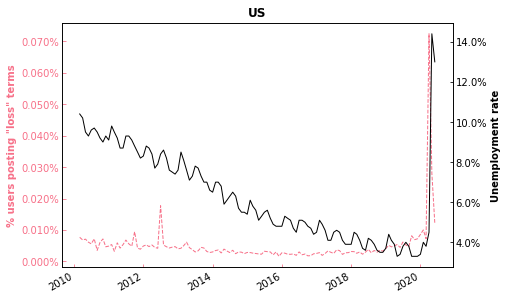

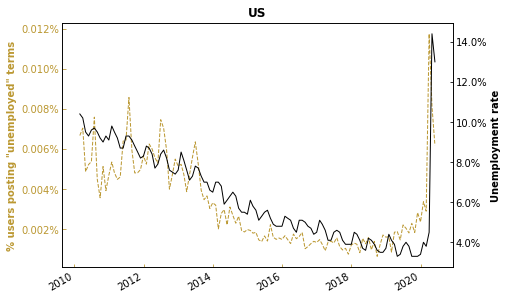

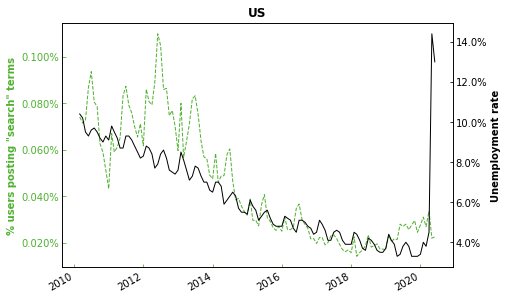

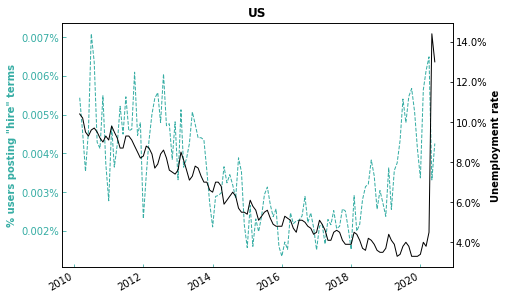

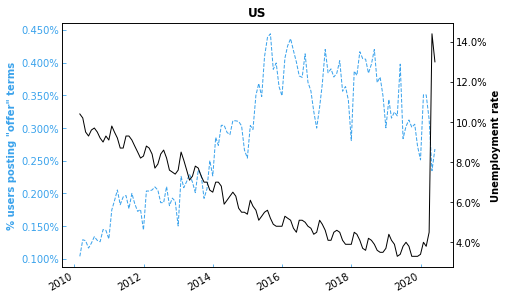

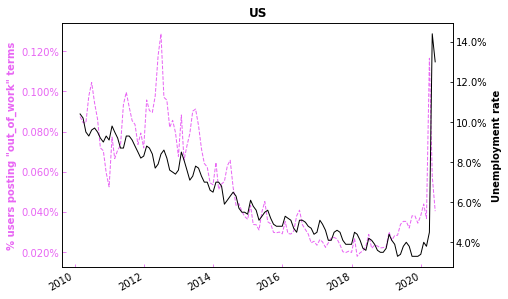

In [101]:
def plot_twitter_data_versus_unemployment_rate(df):
    for i,label in enumerate(labels):
        colors = sns.color_palette("husl", 12)
        fig,ax1=plt.subplots(figsize=(7,5))
        ax2 = ax1.twinx()
        ax1.plot(df['date'],df[label],linewidth=1,color=colors[2*i],linestyle='dashed')
        ax2.plot(df['date'],df['unemployment_rate'],linewidth=1,color='k')
        ax1.tick_params(which='both',direction='in',pad=3,color=colors[2*i])
        ax2.tick_params(which='both',direction='in',pad=3,color='k')
        ax1.locator_params(axis='y',nbins=8)
        ax2.locator_params(axis='y',nbins=8)
        ax1.set_xlabel('')
        ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()],color=colors[2*i])
        ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()],color='k')
        ax1.set_ylabel('% users posting "'+label+'" terms',fontweight='bold',color=colors[2*i])
        ax2.set_ylabel('Unemployment rate',fontweight='bold',color='k')
        ax1.set_title(country_code,fontweight='bold')
        fig.autofmt_xdate()
#         plt.savefig(os.path.join(path_to_data,'../fig/','country',country_code+label+'-'+str(int(q1))+'-'+str(int(q2))+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')
    
plot_twitter_data_versus_unemployment_rate(users_predictions_metro_areas)

# Old version -- to be updated

In [6]:
print('Compute Twitter series by increasing quantile of activity')
start = timer()
df=df1.copy()
for q1 in users_predictions['statuses_per_day_quantile'].sort_values().unique():
    for q2 in users_predictions['account_age_quantile'].sort_values().unique():
        name='statuses_per_day_quantile_'+str(int(q1))+'_account_age_quantile_'+str(int(q2))
        tmp=df2[(df2['statuses_per_day_quantile']>=q1)&(df2['account_age_quantile']>=q2)].drop([
        'statuses_per_day_quantile','account_age_quantile'],1)
        tmp=tmp.groupby(['year','month'],as_index=False).sum()
        tmp[labels]=tmp[labels].divide(tmp['user_id'],0)
        tmp.rename(columns=lambda x:x+'_'+name if x in labels+['user_id'] else x,inplace=True)
        df=df.merge(tmp,how='left')
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)
print("Done in", round(timer()-start), "sec")

Compute Twitter series by increasing quantile of activity
Done in 88 sec


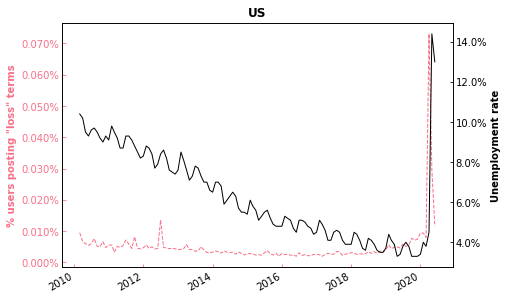

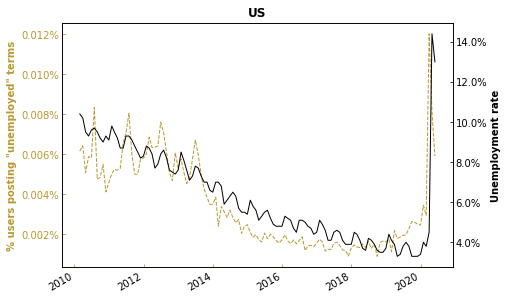

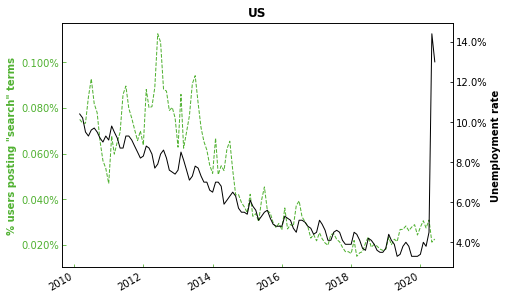

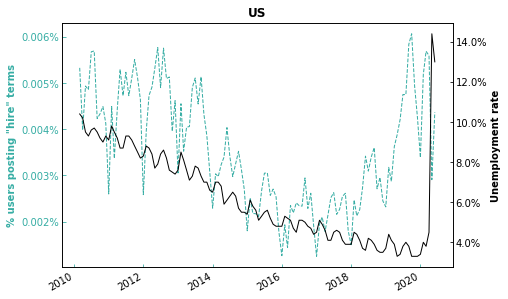

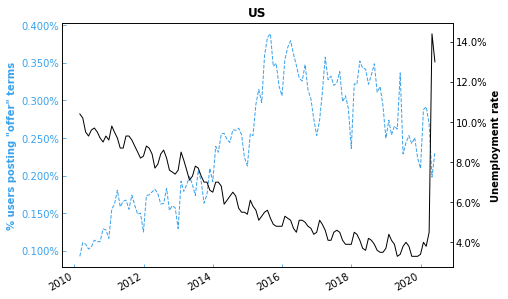

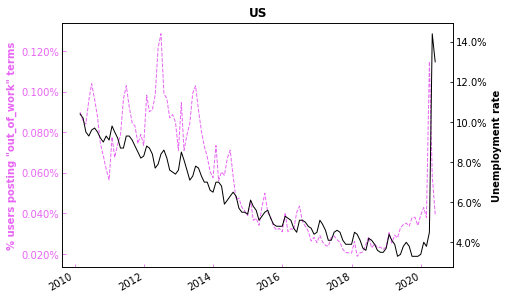

In [7]:
def plot_twitter_data_versus_unemployment_rate(q1,q2):
    for i,label in enumerate(labels):
        colors = sns.color_palette("husl", 12)
        fig,ax1=plt.subplots(figsize=(7,5))
        ax2 = ax1.twinx()
        ax1.plot(df['date'],df[label+'_statuses_per_day_quantile_'+str(int(q1))+'_account_age_quantile_'+str(int(q2))],linewidth=1,color=colors[2*i],linestyle='dashed')
        ax2.plot(df['date'],df['unemployment_rate'],linewidth=1,color='k')
        ax1.tick_params(which='both',direction='in',pad=3,color=colors[2*i])
        ax2.tick_params(which='both',direction='in',pad=3,color='k')
        ax1.locator_params(axis='y',nbins=8)
        ax2.locator_params(axis='y',nbins=8)
        ax1.set_xlabel('')
        ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()],color=colors[2*i])
        ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()],color='k')
        ax1.set_ylabel('% users posting "'+label+'" terms',fontweight='bold',color=colors[2*i])
        ax2.set_ylabel('Unemployment rate',fontweight='bold',color='k')
        ax1.set_title(country_code,fontweight='bold')
        fig.autofmt_xdate()
        plt.savefig(os.path.join(path_to_data,'../fig/','country',country_code+label+'-'+str(int(q1))+'-'+str(int(q2))+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')
    
for q1 in users_predictions['statuses_per_day_quantile'].sort_values().unique()[:1]:
    for q2 in users_predictions['account_age_quantile'].sort_values().unique()[:1]:
        plot_twitter_data_versus_unemployment_rate(q1,q2)

In [8]:
print('In-sample regressions')
def regression_by_users_group(q1,q2):
    group='_statuses_per_day_quantile_'+str(int(q1))+'_account_age_quantile_'+str(int(q2))
    exogs=[['unemployment_lag']]
    for label in sorted(labels):
        exogs.extend([[label],['unemployment_lag',label]])
    models=[]
    for exog in exogs:
        tmp=pd.concat([df.filter(regex='unemployment'),df.filter(regex=group).copy()],1).dropna()
        tmp.rename(columns=lambda x:x.replace(group,''),inplace=True)
        models.append(sm.OLS(endog=tmp['unemployment_rate'],exog=sm.add_constant(tmp[exog])).fit())
    stargazer = Stargazer(models)
    stargazer.dependent_variable_name('Unemployment rate')
    return HTML(stargazer.render_html())

regression_by_users_group(0,0)

In-sample regressions


Out-of-sample Forecasting
Predictions
RMSE


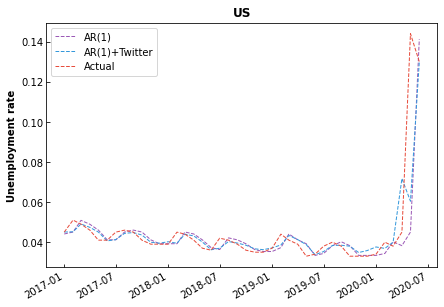

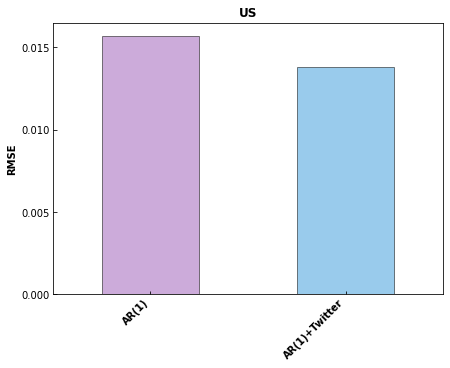

In [9]:
print('Out-of-sample Forecasting')
date_split='31/12/2016'
q1,q2=0,0
group='_statuses_per_day_quantile_'+str(int(q1))+'_account_age_quantile_'+str(int(q2))
exogs=[['unemployment_lag'],labels+['unemployment_lag']]
names=['AR(1)','AR(1)+Twitter']
rmse=[]
y_predict={}
colors=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for (name,exog) in zip(names, exogs):
    
    tmp=pd.concat([df['date'],df.filter(regex='unemployment'),df.filter(regex=group).copy()],1)
    tmp.rename(columns=lambda x:x.replace(group,''),inplace=True)
    train=tmp[tmp['date']<=pd.to_datetime(date_split)].copy()
    test=tmp[tmp['date']>=pd.to_datetime(date_split)].copy()
    model=sm.OLS(endog=train['unemployment_rate'],exog=sm.add_constant(train[exog])).fit()
    y_predict[name]=sm.add_constant(test[exog]).multiply(model.params).sum(1)
    rmse.append((name,np.sqrt(np.mean((test['unemployment_rate']-y_predict[name])**2))))
    
#####################################################################################################################

print('Predictions')
fig,ax=plt.subplots(figsize=(7,5))
for i,name in enumerate(names):
    plt.plot(test['date'],y_predict[name],color=colors[i],linestyle='dashed',linewidth=1,label=name)
# plt.plot(train['date'],train['unemployment_rate'],color=colors[2],linewidth=1)
plt.plot(test['date'],test['unemployment_rate'],color=colors[3],linestyle='dashed',linewidth=1,label='Actual')
ax.tick_params(which='both',direction='in',pad=3)
plt.legend(loc='best')
ax.set_title(country_code,fontweight='bold')
ax.set_ylabel('Unemployment rate',fontweight='bold',color='k')
fig.autofmt_xdate()
plt.savefig(os.path.join(path_to_data,'../fig/','country',country_code+'-predictions'+'-'.join(labels)+'-'+str(int(q1))+'-'+str(int(q2))+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')

#####################################################################################################################

print('RMSE')
fig,ax=plt.subplots(figsize=(7,5))
pd.DataFrame(rmse,columns=['model','RMSE']).set_index('model')['RMSE'].plot(
ax=ax,
kind='bar',
width=.5,    
legend=False, 
stacked=True, 
color=colors,
alpha=0.5,
edgecolor='k')
ax.set_xlabel('')
ax.set_ylabel('RMSE',fontweight='bold',color='k')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right',fontweight='bold')
ax.locator_params(axis='y',nbins=5)
ax.set_title(country_code,fontweight='bold')
plt.savefig(os.path.join(path_to_data,'../fig/','country',country_code+'-rmse'+'-'.join(labels)+'-'+str(int(q1))+'-'+str(int(q2))+'-'+datetime.today().strftime('%Y-%m-%d')+'.pdf'),bbox_inches='tight')